## Energy consumption in Toulouse as in Bueno et al. 2012

The goal of this notebook is to recreate the results for Toulouse as shown in https://gmd.copernicus.org/articles/5/433/2012/

In [1]:
import sys
from pathlib import Path
import f90nml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
THIS_DIR = Path.cwd()
PROJ_DIR = THIS_DIR.parents[1]
sys.path.append(str(PROJ_DIR / 'tools'))
from helpers import run_teb, load_txt, get_date_params

In [3]:
# Run TEB
path_to_teb_exe = PROJ_DIR / 'build' / 'driver'
run_teb(THIS_DIR, path_to_teb_exe, None)

Running case: BUENO_2012


In [4]:
# Read TEB outputs
path_to_case_dir = THIS_DIR
case_nml = path_to_case_dir / 'input.nml'
start, freq = get_date_params(case_nml)

# The start time in TEB is always given in UTC so we convert to local time with local_tz
df_bem = load_txt(path_to_case_dir / 'output', start, freq, local_tz='Europe/Paris')

# Resample and subset to same period used in paper
df_bem = df_bem.resample('1D').mean()
simulation_period = df_bem.loc['2004-12-19' : '2005-02-17'].index
df_bem = df_bem.loc[simulation_period]

In [5]:
# Read obs 
dateparse = lambda x, y: datetime.strptime(f"{x} {y}",'%d/%m/%Y %H:%M:%S.%f')

df_obs = pd.read_csv(THIS_DIR / "obs" / "qf_1800.dat", index_col=['datetime'], names=['date', 'time', 'electric_consumption', 'traffic', 'gas_consumption'], 
                  parse_dates={'datetime': ['date', 'time']}, date_parser=dateparse, delim_whitespace=True)

df_obs = df_obs.resample('1D').mean().tz_localize('Europe/Paris').loc[simulation_period]

/tmp/ipykernel_9360/2097131159.py:4: FutureWarning: 
        Use pd.to_datetime instead.

  df_obs = pd.read_csv(THIS_DIR / "obs" / "qf_1800.dat", index_col=['datetime'], names=['date', 'time', 'electric_consumption', 'traffic', 'gas_consumption'],


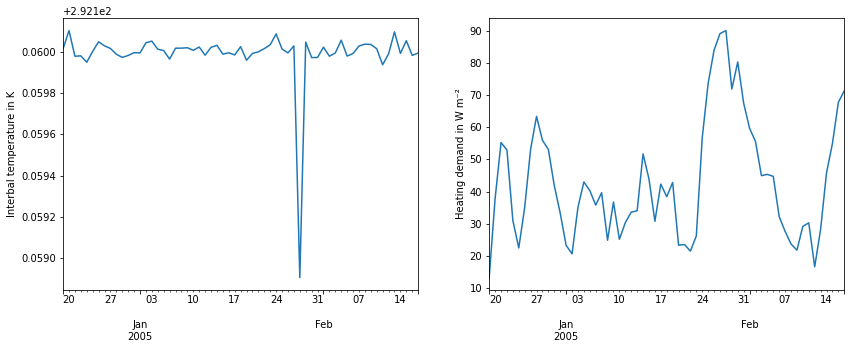

In [6]:
# Plot internal temperature and buiding energy demand to check if envelope is leaky with current parameters
fig, ax = plt.subplots(1,2, figsize=(14,5))
quantity_name = 'TI_BLD'
df_bem[quantity_name].plot(ax=ax[0])
ax[0].set_ylabel("Interbal temperature in K")

quantity_name = 'HVAC_HEAT'
df_bem[quantity_name].plot(ax=ax[1])
ax[1].set_ylabel("Heating demand in W m⁻²");

In [7]:
# Define some funcs used in comparisons
def compute_errors(df_x, df_y, vs):
    diff = df_x - df_y
    mbe = diff.mean()
    rmse = np.sqrt((diff**2).mean())
    print(f"RMSE: {round(rmse, 1)} W m⁻² (urb) vs {vs[0]} W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7")
    print(f"MBE: {round(mbe, 1)} W m⁻² (urb) vs {vs[1]} W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7")
    
def plot_res(df_sim, df_obs, label, vs, fpath_ref):
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    df_sim.plot(ax=ax[0], c='r')
    df_obs.plot(ax=ax[0], c='k', marker="o", linestyle='')
    ax[0].set_xlabel('Datetime')
    ax[0].set_ylabel(label)
    ax[0].legend(['TEB', 'Observed']);
    ax[0].set_ylim([0, 100]);
    ax[1].imshow(plt.imread(fpath_ref))
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
    ax[1].set_title("FIg. 9, page 11\nhttps://gmd.copernicus.org/articles/5/433/2012/")
    
    compute_errors(df_sim, df_obs, vs=vs)

In [8]:
# Calculation of internal gains
internal_heat_gains_per_floor = 5.8 # Table 3, page 9 -> https://gmd.copernicus.org/articles/5/433/2012/
n_floors = 7 # 20 m high building with 3 m high floors
building_density = 0.68 # Table 3, page 9 -> https://gmd.copernicus.org/articles/5/433/2012/
electric_fraction_internal_heat_gains = 0.7 # Table 3, page 9 -> https://gmd.copernicus.org/articles/5/433/2012/
internal_heat_gains_urb_electric = internal_heat_gains_per_floor * n_floors * building_density * \
    electric_fraction_internal_heat_gains
internal_heat_gains_urb_gas = internal_heat_gains_per_floor * n_floors * building_density * \
    (1 - electric_fraction_internal_heat_gains)

# The internal gains seem a bit high...
print(f"Internal electric gains: {internal_heat_gains_urb_electric} W m⁻² (urb)")
print(f"Internal gas gains: {internal_heat_gains_urb_gas}  W m⁻² (urb)")

Internal electric gains: 19.3256 W m⁻² (urb)
Internal gas gains: 8.282400000000003  W m⁻² (urb)


RMSE: 16.9 W m⁻² (urb) vs 5.1 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7
MBE: 14.3 W m⁻² (urb) vs -2.8 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7


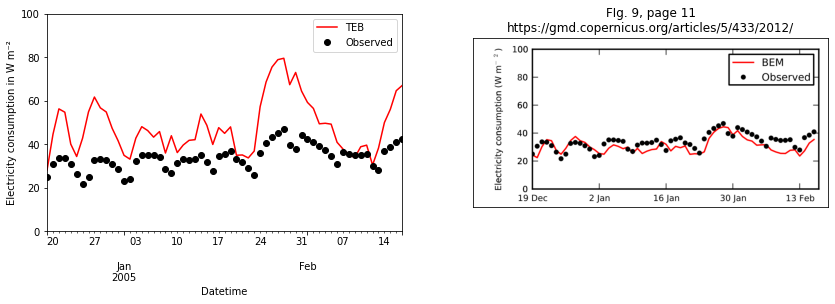

In [9]:
# Electric consumption
frac_electric_over_gas_heating = 2/3
df_bem_electric = df_bem['HVAC_HEAT'] * frac_electric_over_gas_heating + internal_heat_gains_urb_electric
label = 'Electricity consumption in W m⁻²'
vs = (5.1, -2.8)
fpath_ref = THIS_DIR / "obs" / "electric.png"

plot_res(df_bem_electric, df_obs['electric_consumption'], label, vs, fpath_ref)

RMSE: 3.8 W m⁻² (urb) vs 7.4 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7
MBE: -2.4 W m⁻² (urb) vs -6.0 W m⁻² (urb) in https://gmd.copernicus.org/articles/5/433/2012/ Table 2, page 7


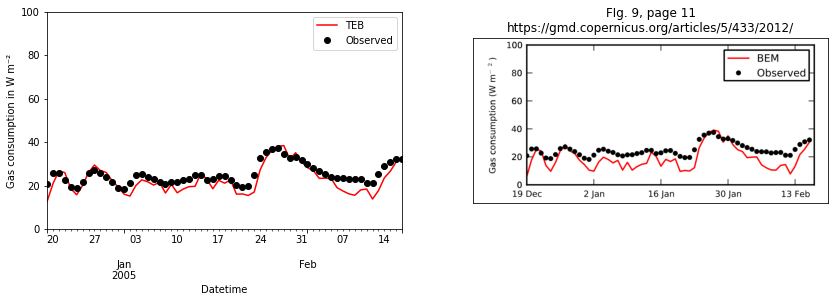

In [10]:
# Gas consumption
df_bem_gas = df_bem['HVAC_HEAT'] * (1 - frac_electric_over_gas_heating) + internal_heat_gains_urb_gas
label = 'Gas consumption in W m⁻²'
vs = (7.4, -6.0)
fpath_ref = THIS_DIR / "obs" / "gas.png"

plot_res(df_bem_gas, df_obs['gas_consumption'], label, vs, fpath_ref)